<a href="https://colab.research.google.com/github/55766sufyan/aritifical_intelligence_chest_xray_pneumonia_semester5/blob/main/notebooks/Phase_1_Data_Loading_%26_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install required packages

In [ ]:
# 1. Install required packages
!pip install -q kaggle
!pip install -q tensorflow keras numpy matplotlib seaborn scikit-learn pillow


2) Upload kaggle.json (Kaggle API token)

In [ ]:
from google.colab import files, drive
import os, shutil

# Mount Drive if not already mounted
drive.mount('/content/drive')

# Upload kaggle.json file interactively
print("Upload kaggle.json (from Kaggle account → API → Create New Token)")
uploaded = files.upload()  # select kaggle.json to upload
for fn in uploaded.keys():
    print('Uploaded file:', fn)

# Move kaggle.json into the correct place
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("kaggle.json moved to /root/.kaggle/kaggle.json")


Mounted at /content/drive
Upload kaggle.json (from Kaggle account → API → Create New Token)


Saving kaggle.json to kaggle.json
Uploaded file: kaggle.json
kaggle.json moved to /root/.kaggle/kaggle.json


3) Download the Chest X-Ray Pneumonia dataset from Kaggle

In [ ]:
# 3. Download dataset (may take a few minutes depending on size)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:24<00:00, 246MB/s]
100% 2.29G/2.29G [00:24<00:00, 102MB/s]


4) Move dataset into your Google Drive prepared folders

In [ ]:
import shutil, os

src = '/content/chest_xray'   # should exist after unzip
dst = '/content/drive/MyDrive/datasets/chest_xray'

# If the dataset root inside src is named differently, list to check
print("Source contents:", os.listdir('/content'))

# Move only if src exists
if os.path.exists(src):
    # If dst already has content, we can merge or overwrite — here we copy non-destructively
    def copy_tree(src, dst):
        for root, dirs, files in os.walk(src):
            rel = os.path.relpath(root, src)
            target_root = os.path.join(dst, rel)
            os.makedirs(target_root, exist_ok=True)
            for f in files:
                sfile = os.path.join(root, f)
                tfile = os.path.join(target_root, f)
                if not os.path.exists(tfile):
                    shutil.copy2(sfile, tfile)
    copy_tree(src, dst)
    print("Dataset copied to Drive:", dst)
else:
    print("Error: downloaded dataset folder not found at", src)


Source contents: ['.config', 'drive', 'chest_xray', 'sample_data']
Dataset copied to Drive: /content/drive/MyDrive/datasets/chest_xray


5) Quick counts: how many images per split/class


In [ ]:
import os

base_dir = '/content/drive/MyDrive/datasets/chest_xray'

def count_images(base):
    for split in ['train','val','test']:
        split_dir = os.path.join(base, split)
        print(f"\n===== {split.upper()} =====")
        if not os.path.exists(split_dir):
            print("  Missing:", split_dir)
            continue
        classes = os.listdir(split_dir)
        for c in classes:
            p = os.path.join(split_dir, c)
            if os.path.isdir(p):
                n = sum([1 for _ in os.scandir(p)])
                print(f"  {c}: {n}")

count_images(base_dir)



===== TRAIN =====
  NORMAL: 1341
  PNEUMONIA: 3875

===== VAL =====
  NORMAL: 8
  PNEUMONIA: 8

===== TEST =====
  NORMAL: 234
  PNEUMONIA: 390


6) Show some sample images from each class

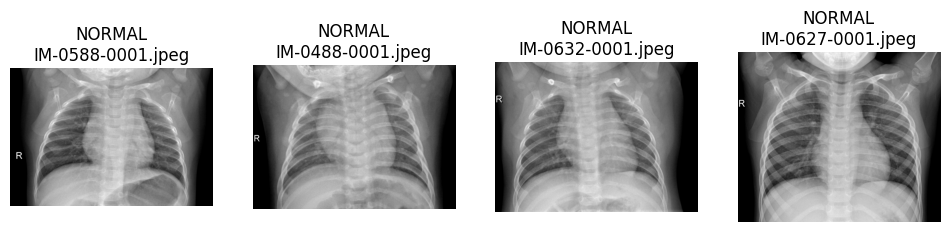

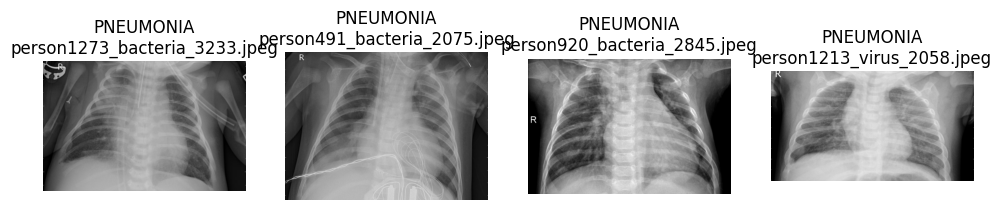

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples(base, split='train', n_per_class=4, size=(6,6)):
    split_dir = os.path.join(base, split)
    classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))]
    for cls in classes:
        folder = os.path.join(split_dir, cls)
        imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        sampled = random.sample(imgs, min(n_per_class, len(imgs)))
        plt.figure(figsize=(12,3))
        for i, imgfile in enumerate(sampled):
            img = Image.open(os.path.join(folder,imgfile)).convert('RGB')
            plt.subplot(1, n_per_class, i+1)
            plt.imshow(img)
            plt.title(f"{cls}\n{imgfile}")
            plt.axis('off')
        plt.show()

# Show 4 samples each from train NORMAL and PNEUMONIA
show_samples(base_dir, split='train', n_per_class=4)


7) Check image sizes / shapes distribution

In [ ]:
from PIL import Image
from collections import Counter

def collect_sizes(base, split='train', max_images=2000):
    sizes = Counter()
    count = 0
    for cls in os.listdir(os.path.join(base, split)):
        folder = os.path.join(base, split, cls)
        for fn in os.listdir(folder):
            if fn.lower().endswith(('.png','.jpg','.jpeg')):
                try:
                    im = Image.open(os.path.join(folder, fn))
                    sizes[im.size] += 1
                except:
                    pass
                count += 1
                if count >= max_images:
                    break
        if count >= max_images:
            break
    return sizes

sizes = collect_sizes(base_dir, split='train', max_images=3000)
print("Most common image sizes (width, height):")
for s,c in sizes.most_common(20):
    print(s, c)


Most common image sizes (width, height):
(968, 576) 4
(1064, 760) 4
(1008, 704) 4
(1440, 992) 3
(984, 520) 3
(1144, 632) 3
(1152, 856) 3
(1216, 728) 3
(1176, 784) 3
(992, 592) 3
(1072, 720) 3
(1128, 736) 3
(1288, 768) 3
(1152, 736) 3
(1504, 992) 3
(1152, 784) 3
(952, 544) 3
(1136, 680) 3
(1072, 744) 3
(1080, 728) 3


8. Create a CSV manifest

In [ ]:
import os
import pandas as pd

base_dir = '/content/drive/MyDrive/datasets/chest_xray'

rows = []

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    if not os.path.exists(split_dir):
        print(f"Missing directory: {split_dir}")
        continue

    for cls in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        # Loop through image files
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                rows.append({
                    'split': split,
                    'class': cls,
                    'filename': file,
                    'path': os.path.join(class_dir, file)
                })

df = pd.DataFrame(rows)

print("Total images:", df.shape[0])
df.head()


Total images: 5856


,split,class,filename,path
0,train,NORMAL,NORMAL2-IM-0855-0001.jpeg,/content/drive/MyDrive/datasets/chest_xray/tra...
1,train,NORMAL,NORMAL2-IM-1147-0001.jpeg,/content/drive/MyDrive/datasets/chest_xray/tra...
2,train,NORMAL,IM-0480-0001.jpeg,/content/drive/MyDrive/datasets/chest_xray/tra...
3,train,NORMAL,NORMAL2-IM-1356-0001.jpeg,/content/drive/MyDrive/datasets/chest_xray/tra...
4,train,NORMAL,NORMAL2-IM-1088-0001.jpeg,/content/drive/MyDrive/datasets/chest_xray/tra...


In [ ]:
csv_path = '/content/drive/MyDrive/datasets/chest_xray/manifest.csv'
df.to_csv(csv_path, index=False)
print("Manifest CSV saved at:", csv_path)


Manifest CSV saved at: /content/drive/MyDrive/datasets/chest_xray/manifest.csv
